In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


In [49]:
def calculate_outliers(df = None):
    """
    Função para calcular os outliers de um dataframe.
    Retorna um dataframe com a quantidade e a porcentagem de outliers por coluna numérica.
    """
    if df is None:
        raise ValueError("O dataframe não pode ser None.")
    if not isinstance(df, pd.DataFrame):
        raise TypeError("O argumento df deve ser um dataframe do pandas.")
    
    numerical_columns = df.select_dtypes(include=['int','float']).columns.tolist()
    outliers = []
    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        mask = (df[column] < lower_limit) | (df[column] > upper_limit)
        qtd_outliers = mask.sum()
        percentage_outliers = (qtd_outliers / df[column].size) * 100
        outliers.append({
            'Column': column,
            'Qtd_outliers': qtd_outliers,
            'Percentage_outliers': percentage_outliers,
        })

    return pd.DataFrame(outliers)

In [50]:
students = pd.read_csv('https://raw.githubusercontent.com/jakobgross/Students-Performance-in-Exams-Kaggle-/refs/heads/master/StudentsPerformance.csv')

In [51]:
students

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [52]:
students.dtypes

gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object

In [53]:
summary_null = pd.DataFrame({
    'Coluna': students.columns,
    'Qtd_null': students.isnull().sum(axis=0).values,
    'Percentage': (students.isnull().mean() * 100).values
})
summary_null

,Coluna,Qtd_null,Percentage
0,gender,0,0.0
1,race/ethnicity,0,0.0
2,parental level of education,0,0.0
3,lunch,0,0.0
4,test preparation course,0,0.0
5,math score,0,0.0
6,reading score,0,0.0
7,writing score,0,0.0


Tratando outliers

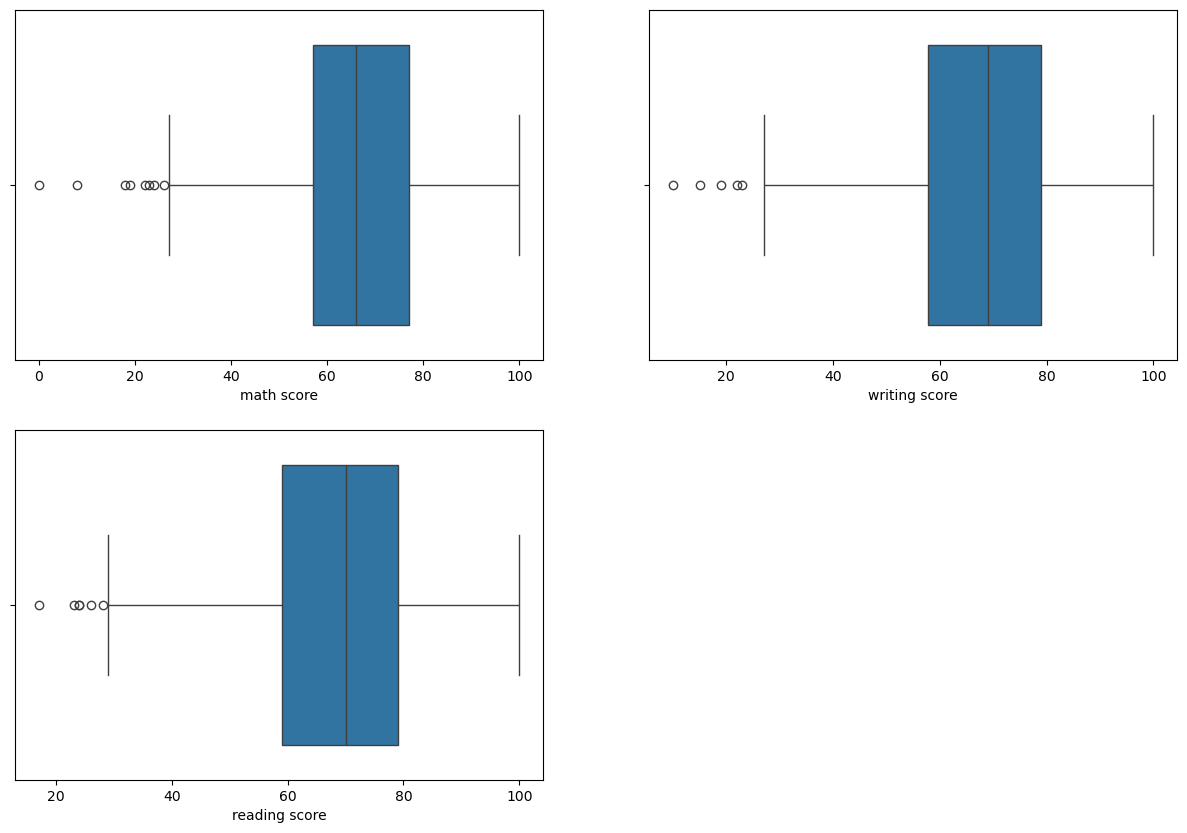

In [54]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
sns.boxplot(data=students, x='math score', ax=ax[0,0])
sns.boxplot(data=students, x='writing score', ax=ax[0,1])
sns.boxplot(data=students, x='reading score', ax=ax[1,0])
ax[1,1].remove()


In [55]:
students_outliers = calculate_outliers(students)
students_outliers


,Column,Qtd_outliers,Percentage_outliers
0,math score,8,0.8
1,reading score,6,0.6
2,writing score,5,0.5


In [56]:
# Capping
students_ = students.copy()
for col in ['math score', 'reading score', 'writing score']:
    Q1 = students_[col].quantile(0.25)
    Q3 = students_[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    students_[col] = np.where(students_[col] < lower_bound, lower_bound, students_[col])
    students_[col] = np.where(students_[col] > upper_bound, upper_bound, students_[col])

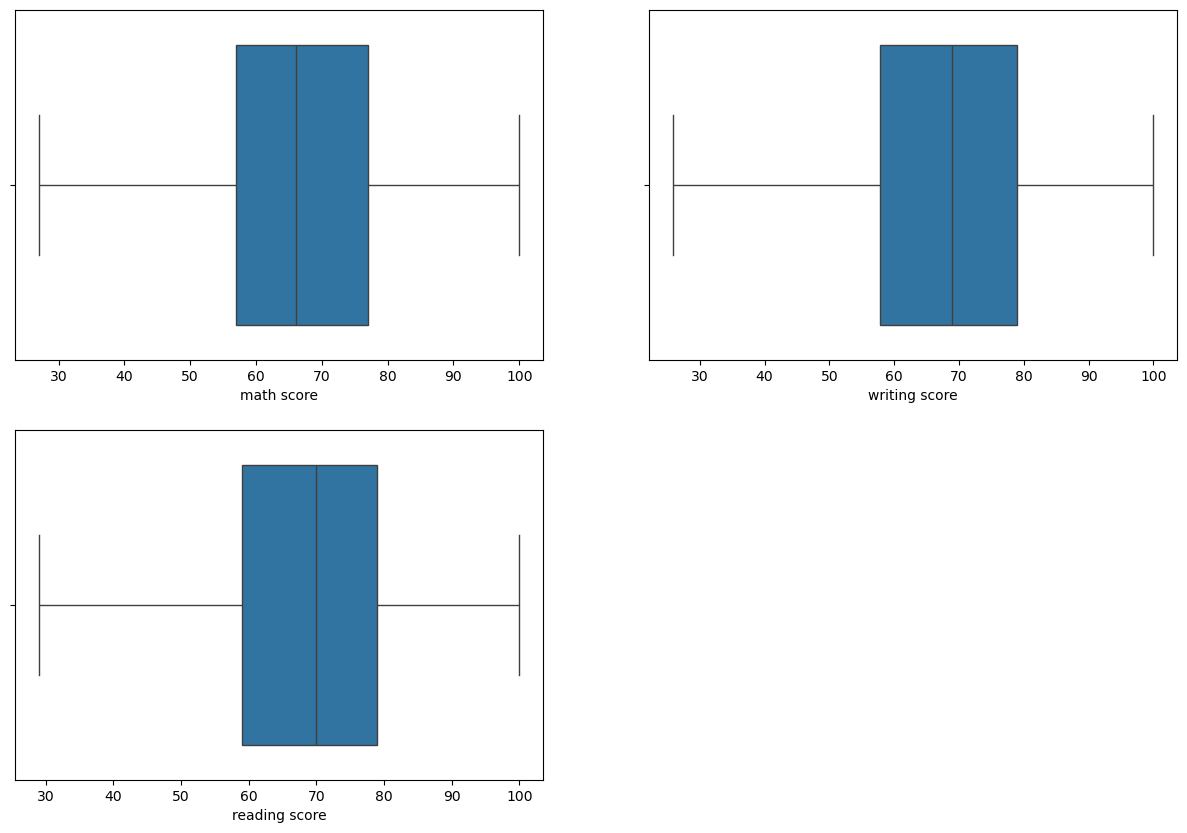

In [57]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
sns.boxplot(data=students_, x='math score', ax=ax[0,0])
sns.boxplot(data=students_, x='writing score', ax=ax[0,1])
sns.boxplot(data=students_, x='reading score', ax=ax[1,0])
ax[1,1].remove()


In [58]:
students_['Performance'] = students_['math score'] + students_['reading score'] + students_['writing score']
students_['Performance']

0      218.0
1      247.0
2      278.0
3      148.0
4      229.0
       ...  
995    282.0
996    172.0
997    195.0
998    223.0
999    249.0
Name: Performance, Length: 1000, dtype: float64

In [59]:
students_ = pd.get_dummies(students_, columns=['gender','race/ethnicity','parental level of education','lunch','test preparation course'], drop_first=True)

In [60]:
x = students_.drop(['Performance','math score', 'reading score', 'writing score'],axis=1)
y = students_[['Performance']]

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

modelo = LinearRegression()
modelo.fit(x_train, y_train)
y_pred = modelo.predict(x_test)

In [62]:
r2_score(y_test, y_pred)

0.22088372091753572

In [63]:
residuos = np.array(y_test).flatten() - y_pred.flatten()

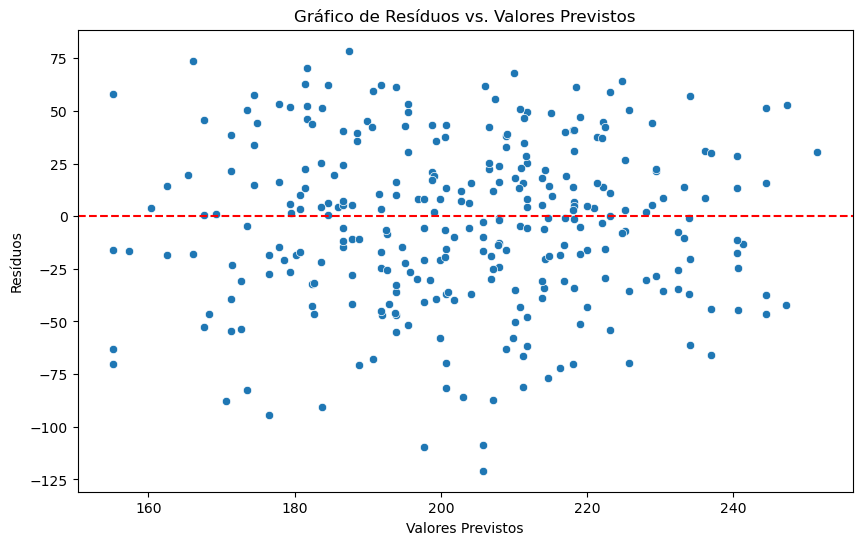

In [64]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred.flatten(), y=residuos)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores Previstos")
plt.ylabel("Resíduos")
plt.title("Gráfico de Resíduos vs. Valores Previstos")
plt.show()

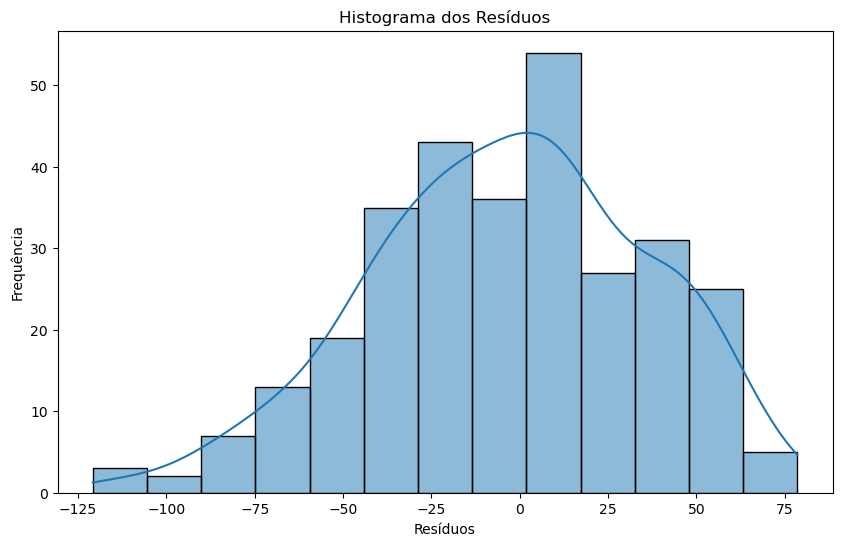

In [65]:
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True) # kde=True adiciona uma estimativa da densidade do kernel
plt.xlabel("Resíduos")
plt.ylabel("Frequência")
plt.title("Histograma dos Resíduos")
plt.show()

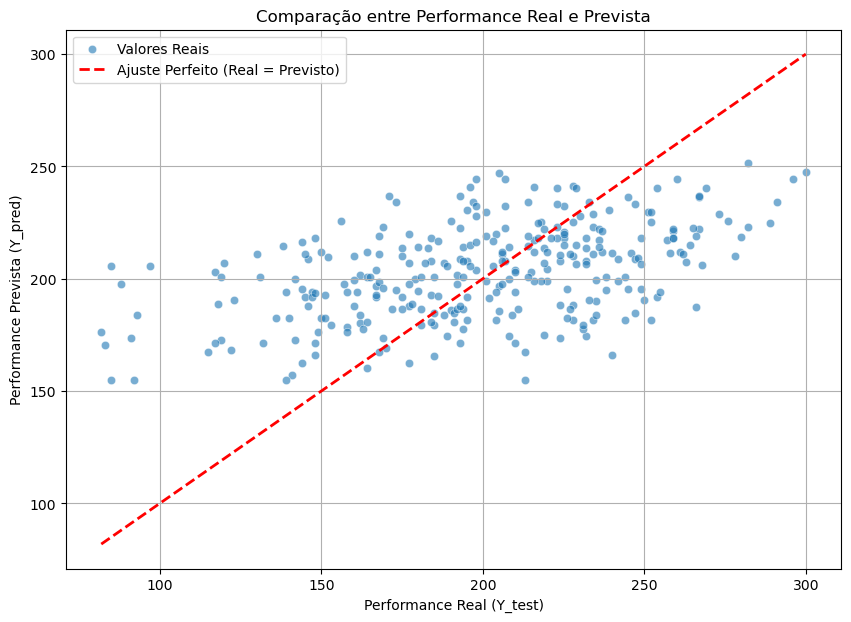

In [66]:
y_pred_flat = y_pred.flatten()
y_test_flat = np.array(y_test).flatten()

plt.figure(figsize=(10, 7))
# Scatter plot dos valores reais vs. valores previstos
sns.scatterplot(x=y_test_flat, y=y_pred_flat, alpha=0.6, label='Valores Reais')
min_val = min(np.min(y_test_flat), np.min(y_pred_flat))
max_val = max(np.max(y_test_flat), np.max(y_pred_flat))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Ajuste Perfeito (Real = Previsto)')

plt.xlabel("Performance Real (Y_test)")
plt.ylabel("Performance Prevista (Y_pred)")
plt.title("Comparação entre Performance Real e Prevista")
plt.legend()
plt.grid(True)
plt.show()

Random Forest

In [67]:
modelo = RandomForestRegressor(max_depth=10, max_leaf_nodes=20,n_estimators=10, random_state=42)

modelo.fit(x_train, y_train)
y_pred = modelo.predict(x_test)

/home/julio/anaconda3/envs/jup_notebook/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [68]:
print(r2_score(y_test, y_pred))

0.14767171024035552


In [75]:

students_cl = students.copy()
students_cl = pd.get_dummies(students_cl, columns=['gender','race/ethnicity','parental level of education','lunch','test preparation course'], drop_first=True)
students_cl


,math score,reading score,writing score,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_standard,test preparation course_none
0,72,72,74,False,True,False,False,False,True,False,False,False,False,True,True
1,69,90,88,False,False,True,False,False,False,False,False,True,False,True,False
2,90,95,93,False,True,False,False,False,False,False,True,False,False,True,True
3,47,57,44,True,False,False,False,False,False,False,False,False,False,False,True
4,76,78,75,True,False,True,False,False,False,False,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,88,99,95,False,False,False,False,True,False,False,True,False,False,True,False
996,62,55,55,True,False,True,False,False,False,True,False,False,False,False,True
997,59,71,65,False,False,True,False,False,False,True,False,False,False,False,False
998,68,78,77,False,False,False,True,False,False,False,False,True,False,True,False


In [76]:

x = students_cl.drop(['test preparation course_none'],axis=1)
y = students_cl[['test preparation course_none']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [149]:
modelo =  RandomForestClassifier(max_depth=30, max_leaf_nodes=50,n_estimators=60, random_state=42)
modelo.fit(x_train, y_train)
y_pred = modelo.predict(x_test)
y_pred_train = modelo.predict(x_train)

/home/julio/anaconda3/envs/jup_notebook/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [150]:
print(accuracy_score(y_test, y_pred))
print(accuracy_score(y_train, y_pred_train))


0.7033333333333334
0.8471428571428572


Text(50.722222222222214, 0.5, 'y_pred')

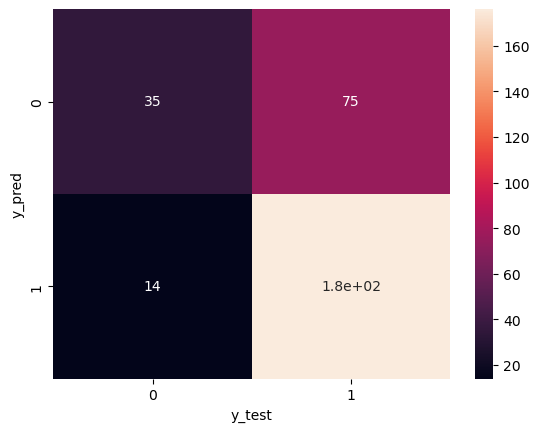

In [148]:
conf_m = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_m, annot=True)
plt.xlabel('y_test')
plt.ylabel('y_pred')